# Spatially Explicit Markov Methods 

**Author: Serge Rey <sjsrey@gmail.com>, Wei Kang <weikang9009@gmail.com>**

## Introduction

This notebook introduces Discrete Markov Chains (DMC) model and its two variants which explicitly incorporate spatial effects. We will demonstrate the usage of these methods by an empirical study for understanding [regional income dynamics in the US](#Regional-income-dynamics-in-the-US). The dataset is the per capita incomes observed annually from 1929 to 2009 for the lower 48 US states.

* [Classic Markov](#Classic-Markov)
* [Spatial Markov](#Spatial-Markov)
* [LISA Markov](#LISA-Markov)

Note that a full execution of this notebook requires **pandas**, **matplotlib** and light-weight geovisualization package pysal-**splot**.

### Classic Markov

```
giddy.markov.Markov(self, class_ids, classes=None)
```

We start with a look at a simple example of classic DMC methods implemented in PySAL-giddy. A Markov chain may be in one of $k$ different states/classes at any point in time. These states are exhaustive and mutually exclusive. If one had a time series of remote sensing images used to develop land use classifications, then the states could be defined as the specific land use classes and interest would center on the transitions in and out of different classes for each pixel.

For example, suppose there are 5 pixels, each of which takes on one of 3 states (a,b,c) at 3 consecutive periods:

In [1]:
import numpy as np
c = np.array([['b','a','c'],['c','c','a'],['c','b','c'],['a','a','b'],['a','b','c']])

So the first pixel was in state ‘b’ in period 1, state ‘a’ in period 2, and state ‘c’ in period 3. Each pixel's trajectory (row) owns [Markov property](https://en.wikipedia.org/wiki/Markov_property), meaning that which state a pixel takes on today is only dependent on its immediate past.  

Let's suppose that all the 5 pixels are governed by the same transition dynamics rule. That is, each trajectory is a realization of a Discrete Markov Chain process. We could pool all the 5 trajectories from which to estimate a transition probability matrix. To do that, we utlize the **Markov** class in **giddy**:

In [2]:
import giddy
m = giddy.markov.Markov(c)

In this way, we create a **Markov** instance - $m$. Its attribute $classes$ gives 3 unique classes these pixels can take on, which are 'a','b' and 'c'.

In [3]:
print(m.classes)

['a' 'b' 'c']


In [4]:
print(len(m.classes))

3


In addition to extracting the unique states as an attribute, our **Markov** instance will also have the attribute *trnasitions* which is a transition matrix counting the number of transitions from one state to another. Since there are 3 unique states, we will have a $(3,3)$ transtion matrix:

In [5]:
print(m.transitions)

[[1. 2. 1.]
 [1. 0. 2.]
 [1. 1. 1.]]


The above transition matrix indicates that of the four pixels that began a transition interval in state ‘a’, 1 remained in that state, 2 transitioned to state ‘b’ and 1 transitioned to state ‘c’. Another attribute $p$ gives the transtion probability matrix which is the transition dynamics rule ubiquitous to all the 5 pixels across the 3 periods. The maximum likehood estimator for each element $p_{i,j}$ is shown below where $n_{i,j}$ is the number of transitions from state $i$ to state $j$ and $k$ is the number of states (here $k=3$):

$$\hat{p}_{i,j} = \frac{n_{i,j}}{\sum_{q=1}^k n_{i,q} }$$


In [6]:
print(m.p)

[[0.25       0.5        0.25      ]
 [0.33333333 0.         0.66666667]
 [0.33333333 0.33333333 0.33333333]]


This means that if any of the 5 pixels was in state 'c', the probability of staying at 'c' or transitioning to any other states ('a', 'b') in the next period is the same (0.333). If a pixel was in state 'b', there is a high possibility that it would take on state 'c' in the next period because $\hat{p}_{2,3}=0.667$.  


In [7]:
m.steady_state  # steady state distribution

array([0.30769231, 0.28846154, 0.40384615])

This simple example illustrates the basic creation of a Markov instance, but the small sample size makes it unrealistic for the more advanced features of this approach. For a larger example, we will look at an application of Markov methods to understanding regional income dynamics in the US. Here we will load in data on per capita incomes observed annually from 1929 to 2010 for the lower 48 US states:

#### Regional income dynamics in the US
Firstly, we load in data on per capita incomes observed annually from 1929 to 2009 for the lower 48 US states. We use the example dataset in [**libpysal**](https://github.com/pysal/libpysal) which was downloaded from [US Bureau of Economic Analysis](https://www.bea.gov).

In [8]:
import libpysal
f = libpysal.open(libpysal.examples.get_path("usjoin.csv"))
pci = np.array([f.by_col[str(y)] for y in range(1929,2010)])
print(pci.shape)

(81, 48)


The first row of the array is the per capita incomes for the 48 US states for the year 1929:

In [9]:
print(pci[0, :])

[ 323  600  310  991  634 1024 1032  518  347  507  948  607  581  532
  393  414  601  768  906  790  599  286  621  592  596  868  686  918
  410 1152  332  382  771  455  668  772  874  271  426  378  479  551
  634  434  741  460  673  675]


In order to apply the classic Markov approach to this series, we first have to discretize the distribution by defining our classes. There are many ways to do this including quantiles classification scheme, equal interval classification scheme, Fisher Jenks classification scheme, etc. For a list of classification methods, please refer to the pysal package [**mapclassify**](https://github.com/pysal/mapclassify). 

Here we will use the quintiles for each annual income distribution to define the classes. It should be noted that using quintiles for the pooled income distribution to define the classes will result in a different interpretation of the income dynamics. Quintiles for each annual income distribution (the former) will reveal more of relative income dynamics while those for the pooled income distribution (the latter) will provide insights in absolute dynamics.

Text(0.5,1,'Absolute Dynamics')

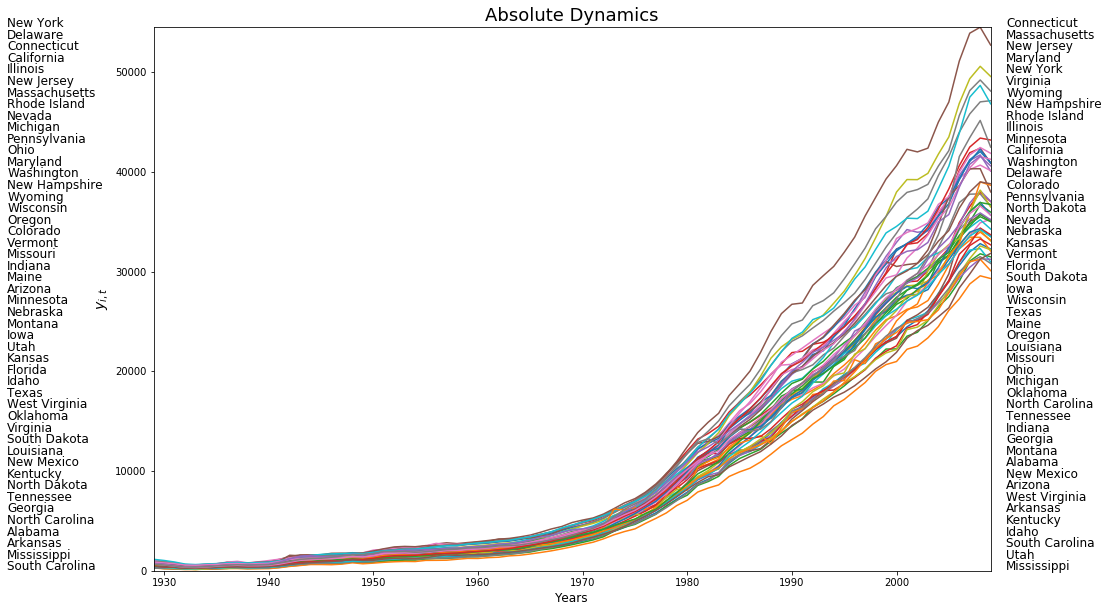

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
years = range(1929,2010)
names = np.array(f.by_col("Name"))
order1929 = np.argsort(pci[0,:])
order2009 = np.argsort(pci[-1,:])
names1929 = names[order1929[::-1]]
names2009 = names[order2009[::-1]]
first_last = np.vstack((names1929,names2009))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
plt.plot(years,pci)
for i in range(48):
    plt.text(1915,54530-(i*1159), first_last[0][i],fontsize=12)
    plt.text(2010.5,54530-(i*1159), first_last[1][i],fontsize=12)
plt.xlim((years[0], years[-1]))
plt.ylim((0, 54530))
plt.ylabel(r"$y_{i,t}$",fontsize=14)
plt.xlabel('Years',fontsize=12)
plt.title('Absolute Dynamics',fontsize=18)

Text(0.5,1,'Relative Dynamics')

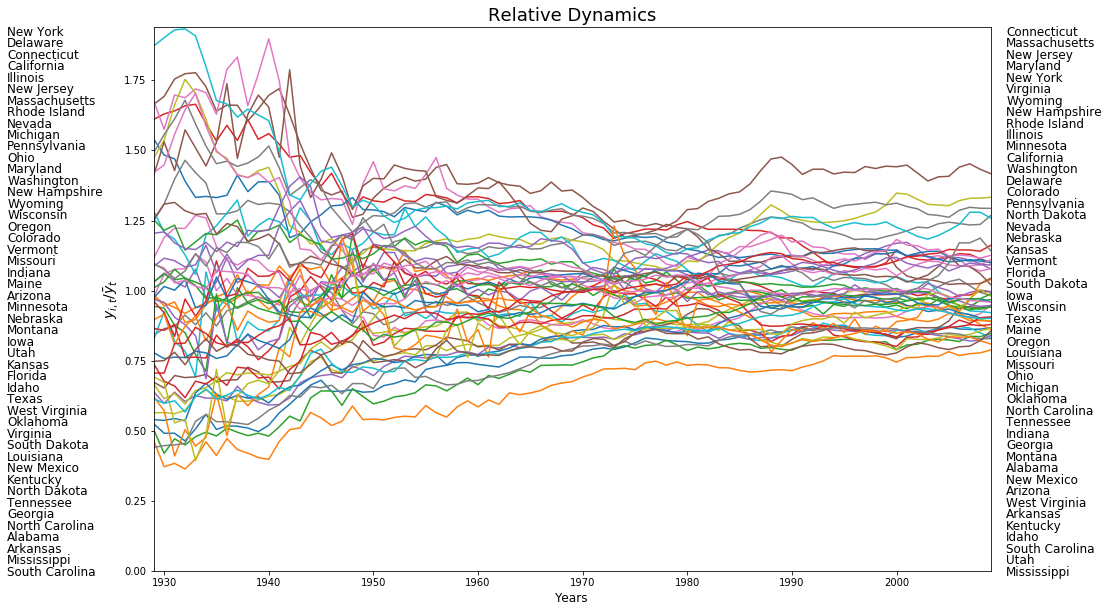

In [11]:
years = range(1929,2010)
rpci= (pci.T / pci.mean(axis=1)).T
names = np.array(f.by_col("Name"))
order1929 = np.argsort(rpci[0,:])
order2009 = np.argsort(rpci[-1,:])
names1929 = names[order1929[::-1]]
names2009 = names[order2009[::-1]]
first_last = np.vstack((names1929,names2009))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
plt.plot(years,rpci)
for i in range(48):
    plt.text(1915,1.91-(i*0.041), first_last[0][i],fontsize=12)
    plt.text(2010.5,1.91-(i*0.041), first_last[1][i],fontsize=12)
plt.xlim((years[0], years[-1]))
plt.ylim((0, 1.94))
plt.ylabel(r"$y_{i,t}/\bar{y}_t$",fontsize=14)
plt.xlabel('Years',fontsize=12)
plt.title('Relative Dynamics',fontsize=18)

In [12]:
import mapclassify.api as mc
q5 = np.array([mc.Quantiles(y,k=5).yb for y in pci]).transpose()
print(q5[:, 0])

[0 2 0 4 2 4 4 1 0 1 4 2 2 1 0 1 2 3 4 4 2 0 2 2 2 4 3 4 0 4 0 0 3 1 3 3 4
 0 1 0 1 2 2 1 3 1 3 3]


In [13]:
print(f.by_col("Name"))

['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


A number of things need to be noted here. First, we are relying on the classification methods in [**mapclassify**](https://github.com/pysal/mapclassify) for defining our quintiles. The class *Quantiles* uses quintiles ($k=5$) as the default and will create an instance of this class that has multiple attributes, the one we are extracting in the first line is $yb$ - the class id for each observation. The second thing to note is the transpose operator which gets our resulting array $q5$ in the proper structure required for use of Markov. Thus we see that the first spatial unit (Alabama with an income of 323) fell in the first quintile in 1929, while the last unit (Wyoming with an income of 675) fell in the fourth quintile.

So now we have a time series for each state of its quintile membership. For example, Colorado’s quintile time series is:

In [14]:
print(q5[4, :])

[2 3 2 2 3 2 2 3 2 2 2 2 2 2 2 2 3 2 3 2 3 2 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 3 3 3 4 3 3 3]


indicating that it has occupied the 3rd, 4th and 5th quintiles in the distribution at the first 3 periods. To summarize the transition dynamics for all units, we instantiate a Markov object:

In [15]:
m5 = giddy.markov.Markov(q5)

The number of transitions between any two quintile classes could be counted:

In [16]:
print(m5.transitions)

[[729.  71.   1.   0.   0.]
 [ 72. 567.  80.   3.   0.]
 [  0.  81. 631.  86.   2.]
 [  0.   3.  86. 573.  56.]
 [  0.   0.   1.  57. 741.]]


By assuming the first-order Markov property, time homogeneity, spatial homogeneity and spatial independence, a transition probability matrix could be estimated which holds for all the 48 US states across 1929-2010:

In [17]:
print(m5.p)

[[0.91011236 0.0886392  0.00124844 0.         0.        ]
 [0.09972299 0.78531856 0.11080332 0.00415512 0.        ]
 [0.         0.10125    0.78875    0.1075     0.0025    ]
 [0.         0.00417827 0.11977716 0.79805014 0.07799443]
 [0.         0.         0.00125156 0.07133917 0.92740926]]


The fact that each of the 5 diagonal elements is larger than $0.78$ indicates a high stability of US regional income dynamics system.

Another very important feature of DMC model is the steady state distribution $\pi$ (also called limiting distribution) defined as $\pi p = \pi$. The attribute $steady\_state$ gives $\pi$ as follows:

In [18]:
print(m5.steady_state)

[0.20774716 0.18725774 0.20740537 0.18821787 0.20937187]


If the distribution at $t$ is a steady state distribution as shown above, then any distribution afterwards is the same distribution. 

With the transition probability matrix in hand, we can estimate the first mean passage time which is the average number of steps to go from a state/class to another state for the first time:

In [19]:
print(giddy.ergodic.fmpt(m5.p))

[[  4.81354357  11.50292712  29.60921231  53.38594954 103.59816743]
 [ 42.04774505   5.34023324  18.74455332  42.50023268  92.71316899]
 [ 69.25849753  27.21075248   4.82147603  25.27184624  75.43305672]
 [ 84.90689329  42.85914824  17.18082642   5.31299186  51.60953369]
 [ 98.41295543  56.36521038  30.66046735  14.21158356   4.77619083]]


Thus, for a state with income in the first quintile, it takes on average 11.5 years for it to first enter the second quintile, 29.6 to get to the third quintile, 53.4 years to enter the fourth, and 103.6 years to reach the richest quintile.

#### Regional context and Moran's Is

Thus far we have treated all the spatial units as independent to estimate the transition probabilities. This hides an implicit assumption: the movement of a spatial unit in the income distribution is independent of the movement of its neighbors or the position of the neighbors in the distribution. But what if spatial context matters??

We could plot the choropleth maps of per capita incomes of US states to get a first impression of the spatial distribution.

In [20]:
import geopandas as gpd
import pandas as pd

In [21]:
geo_table = gpd.read_file(libpysal.examples.get_path('us48.shp'))
income_table = pd.read_csv(libpysal.examples.get_path("usjoin.csv"))
complete_table = geo_table.merge(income_table,left_on='STATE_NAME',right_on='Name')
complete_table.head()

,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS_x,SUB_REGION,STATE_ABBR,geometry,Name,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,20.750,34.956,1,1,Washington,53,Pacific,WA,(POLYGON ((-122.400749206543 48.22539520263672...,Washington,...,31528,32053,32206,32934,34984,35738,38477,40782,41588,40619
1,45.132,34.527,2,2,Montana,30,Mtn,MT,POLYGON ((-111.4746322631836 44.70223999023438...,Montana,...,22569,24342,24699,25963,27517,28987,30942,32625,33293,32699
2,9.571,18.899,3,3,Maine,23,N Eng,ME,(POLYGON ((-69.77778625488281 44.0740737915039...,Maine,...,25623,27068,27731,28727,30201,30721,32340,33620,34906,35268
3,21.874,21.353,4,4,North Dakota,38,W N Cen,ND,POLYGON ((-98.73005676269531 45.93829727172852...,North Dakota,...,25068,26118,26770,29109,29676,31644,32856,35882,39009,38672
4,22.598,22.746,5,5,South Dakota,46,W N Cen,SD,POLYGON ((-102.7879333496094 42.99532318115234...,South Dakota,...,26115,27531,27727,30072,31765,32726,33320,35998,38188,36499


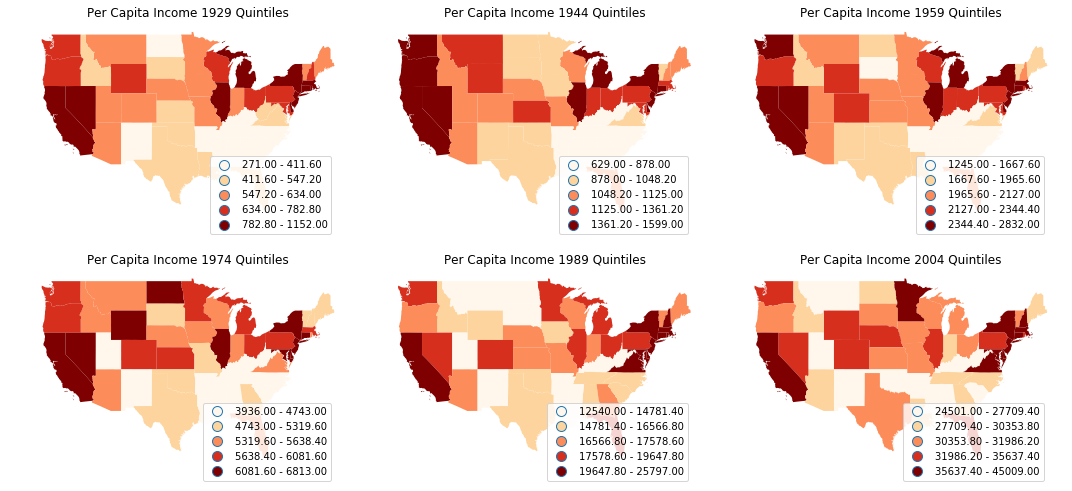

In [22]:
index_year = range(1929,2010,15)
fig, axes = plt.subplots(nrows=2, ncols=3,figsize = (15,7))
for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        complete_table.plot(ax=ax, column=str(index_year[i*3+j]), cmap='OrRd', scheme='quantiles', legend=True)
        ax.set_title('Per Capita Income %s Quintiles'%str(index_year[i*3+j]))
        ax.axis('off')
        leg = ax.get_legend()
        leg.set_bbox_to_anchor((0.8, 0.15, 0.16, 0.2))
plt.tight_layout()

It is quite obvious that the per capita incomes are not randomly distributed: we could spot clusters in the mid-south, south-east and north-east. Let's proceed to calculate Moran's I, a widely used measure of global spatial autocorrelation, to aid the visual interpretation.

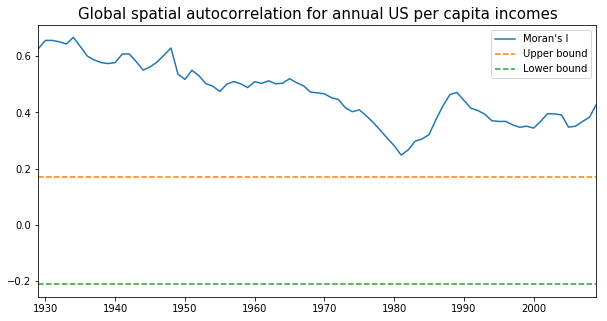

In [23]:
from esda.moran import Moran
import matplotlib.pyplot as plt
%matplotlib inline
w = libpysal.open(libpysal.examples.get_path("states48.gal")).read()
w.transform = 'R'
mits = [Moran(cs, w) for cs in pci]
res = np.array([(mi.I, mi.EI, mi.seI_norm, mi.sim[974]) for mi in mits])
years = np.arange(1929,2010)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (10,5) )
ax.plot(years, res[:,0], label='Moran\'s I')
#plot(years, res[:,1], label='E[I]')
ax.plot(years, res[:,1]+1.96*res[:,2], label='Upper bound',linestyle='dashed')
ax.plot(years, res[:,1]-1.96*res[:,2], label='Lower bound',linestyle='dashed')
ax.set_title("Global spatial autocorrelation for annual US per capita incomes",fontdict={'fontsize':15})
ax.set_xlim([1929,2009])
ax.legend()

From the above figure we could observe that Moran's I value was always positive and significant for each year across 1929-2009. In other words, US regional income series are not independent of each other and regional context could be important in shaping the regional income dynamics. However, the classic Markov approach is silent on this issue. 
We turn to the spatially explict Markov methods - **Spatial Markov** and **LISA Markov** - for an explicit incorporation of space in understanding US regional income distribution dynamics.

### [Spatial Markov](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2001.tb00444.x/full)

```
giddy.markov.Spatial_Markov(y, w, k=4, m=4, permutations=0, fixed=True, discrete=False, cutoffs=None, lag_cutoffs=None, variable_name=None)
```

Spatial Markov is an extension to class Markov allowing for a more comprehensive analysis of the spatial dimensions of the transitional dynamics (Rey, 2001). Here, whether the transition probabilities are dependent on regional context is investigated and quantified. Rather than estimating one transition probability matrix, spatial Markov requires estimation of $k$ transition probability matrices, each of which is conditional on the regional context at the preceding period. The regional context is usually formalized by spatial lag - the weighted average income level of neighbors:

$$z_{r,t} = \sum_{s=1}^{n} w_{r,s} y_{s,t}$$

where $W$ is the spatial weight matrix and $w_{r,s}$ represents the weight that spatial unit $s$ contributes to the local context of spatial unit $r$ at time period $t$.

Similar to the construction of a **Markov** instance, we could create a **Spatial Markov** instance by utilizing the $Spatial\_Markov$ class in **giddy**. The only difference between the adoption of $Markov$ and $Spatial\_Markov$ class is that the latter accepts the original continuous income data while the former requires a pre-classification/discretization. In other words, here we do not need to apply the classification methods in [**mapclassify**](https://github.com/pysal/mapclassify) as we did earlier. In fact, the **Spatial Markov** class nested the quantile classification methods and all we need to do is set the desired number of classes $k$ when creating the $Spatial\_Markov$ instance. Here, we set $k=5$ (quintile classes) as before.

Different from before, quintiles are defined for the pooled relative incomes (by standardizing by each period by the mean). This is achieved by setting the parameter $fixed$ as *True*. 

In [24]:
giddy.markov.Spatial_Markov?

In [25]:
sm = giddy.markov.Spatial_Markov(rpci.T, w, fixed = True, k = 5,m=5) # spatial_markov instance o 

We can next examine the global transition probability matrix for relative incomes.

In [26]:
print(sm.p)

[[0.91461837 0.07503234 0.00905563 0.00129366 0.        ]
 [0.06570302 0.82654402 0.10512484 0.00131406 0.00131406]
 [0.00520833 0.10286458 0.79427083 0.09505208 0.00260417]
 [0.         0.00913838 0.09399478 0.84856397 0.04830287]
 [0.         0.         0.         0.06217617 0.93782383]]


The Spatial Markov allows us to compare the global transition dynamics to those conditioned on regional context. More specifically, the transition dynamics are split across economies who have spatial lags in different quintiles at the preceding year. In our example we have 5 classes, so 5 different conditioned transition probability matrices are estimated - P(LAG0), P(LAG1), P(LAG2), P(LAG3), and P(LAG4).

In [27]:
sm.summary()

--------------------------------------------------------------
                     Spatial Markov Test                      
--------------------------------------------------------------
Number of classes: 5
Number of transitions: 3840
Number of regimes: 5
Regime names: LAG0, LAG1, LAG2, LAG3, LAG4
--------------------------------------------------------------
   Test                   LR                Chi-2
  Stat.              170.659              200.624
    DOF                   60                   60
p-value                0.000                0.000
--------------------------------------------------------------
P(H0)           C0         C1         C2         C3         C4
     C0      0.915      0.075      0.009      0.001      0.000
     C1      0.066      0.827      0.105      0.001      0.001
     C2      0.005      0.103      0.794      0.095      0.003
     C3      0.000      0.009      0.094      0.849      0.048
     C4      0.000      0.000      0.000      0.062      

#### Visualize the (spatial) Markov transition probability matrix

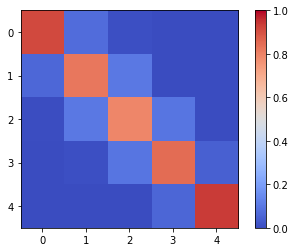

In [28]:
plt.imshow(sm.p,cmap = "coolwarm",vmin=0, vmax=1)
plt.colorbar()

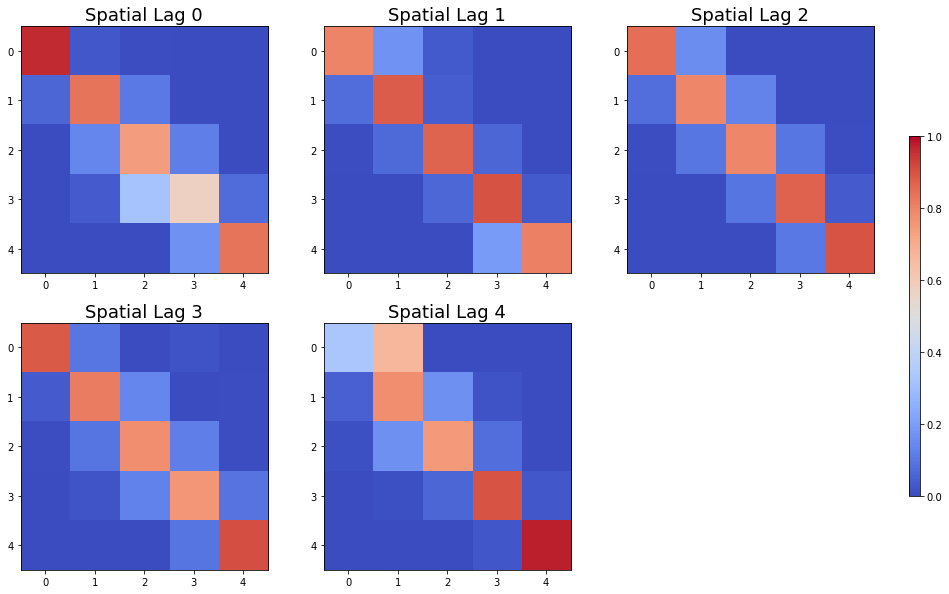

In [29]:
fig, axes = plt.subplots(2,3,figsize = (15,10)) 

for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if i==1 and j==2:
            ax.axis('off')
            continue
        im = ax.imshow(sm.P[i*3+j],cmap = "coolwarm",vmin=0, vmax=1)
        ax.set_title("Spatial Lag %d"%(i*3+j),fontsize=18) 
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.228, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

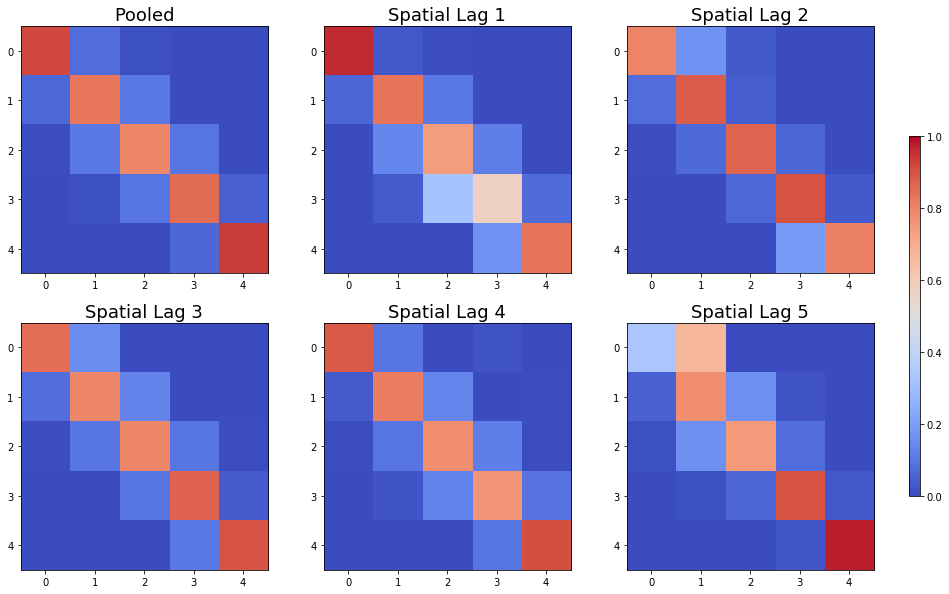

In [30]:
fig, axes = plt.subplots(2,3,figsize = (15,10)) 
for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if i==0 and j==0:
            im = ax.imshow(sm.p,cmap = "coolwarm",vmin=0, vmax=1)
            ax.set_title("Pooled",fontsize=18) 
        else:
            im = ax.imshow(sm.P[i*3+j-1],cmap = "coolwarm",vmin=0, vmax=1)
            ax.set_title("Spatial Lag %d"%(i*3+j),fontsize=18) 
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.228, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)
#fig.savefig('spatial_markov_us.png', dpi = 300)

The probability of a poor state remaining poor is 0.963 if their neighbors are in the 1st quintile and 0.798 if their neighbors are in the 2nd quintile. The probability of a rich economy remaining rich is 0.977 if their neighbors are in the 5th quintile, but if their neighbors are in the 4th quintile this drops to 0.903.

We can also explore the different steady state distributions implied by these different transition probabilities:

In [31]:
print(sm.S)

[[0.43509425 0.2635327  0.20363044 0.06841983 0.02932278]
 [0.13391287 0.33993305 0.25153036 0.23343016 0.04119356]
 [0.12124869 0.21137444 0.2635101  0.29013417 0.1137326 ]
 [0.0776413  0.19748806 0.25352636 0.22480415 0.24654013]
 [0.01776781 0.19964349 0.19009833 0.25524697 0.3372434 ]]


The long run distribution for states with poor (rich) neighbors has 0.435 (0.018) of the values in the first quintile, 0.263 (0.200) in the second quintile, 0.204 (0.190) in the third, 0.0684 (0.255) in the fourth and 0.029 (0.337) in the fifth quintile. And, finally the spatially conditional first mean passage times:

In [32]:
print(sm.F)

[[[  2.29835259  28.95614035  46.14285714  80.80952381 279.42857143]
  [ 33.86549708   3.79459555  22.57142857  57.23809524 255.85714286]
  [ 43.60233918   9.73684211   4.91085714  34.66666667 233.28571429]
  [ 46.62865497  12.76315789   6.25714286  14.61564626 198.61904762]
  [ 52.62865497  18.76315789  12.25714286   6.          34.1031746 ]]

 [[  7.46754205   9.70574606  25.76785714  74.53116883 194.23446197]
  [ 27.76691978   2.94175577  24.97142857  73.73474026 193.4380334 ]
  [ 53.57477715  28.48447637   3.97566318  48.76331169 168.46660482]
  [ 72.03631562  46.94601483  18.46153846   4.28393653 119.70329314]
  [ 77.17917276  52.08887197  23.6043956    5.14285714  24.27564033]]

 [[  8.24751154   6.53333333  18.38765432  40.70864198 112.76732026]
  [ 47.35040872   4.73094099  11.85432099  34.17530864 106.23398693]
  [ 69.42288828  24.76666667   3.794921    22.32098765  94.37966594]
  [ 83.72288828  39.06666667  14.3          3.44668119  76.36702977]
  [ 93.52288828  48.86666667  

States in the first income quintile with neighbors in the first quintile return to the first quintile after 2.298 years, after leaving the first quintile. They enter the fourth quintile 80.810 years after leaving the first quintile, on average. Poor states within neighbors in the fourth quintile return to the first quintile, on average, after 12.88 years, and would enter the fourth quintile after 28.473 years.

Tests for this conditional type of spatial dependence include Likelihood Ratio (LR) test and $\chi^2$ test (Bickenbach and Bode, 2003) as well as a test based on information theory (Kullback et al., 1962). For the first two tests, we could proceed as follows to acquire their statistics, DOF and p-value.

In [33]:
giddy.markov.Homogeneity_Results(sm.T).summary()

--------------------------------------------------
             Markov Homogeneity Test              
--------------------------------------------------
Number of classes: 5
Number of transitions: 3840
Number of regimes: 5
Regime names: 0, 1, 2, 3, 4
--------------------------------------------------
   Test                   LR                Chi-2
  Stat.              170.659              200.624
    DOF                   60                   60
p-value                0.000                0.000
--------------------------------------------------
P(H0)        0        1        2        3        4
    0    0.915    0.075    0.009    0.001    0.000
    1    0.066    0.827    0.105    0.001    0.001
    2    0.005    0.103    0.794    0.095    0.003
    3    0.000    0.009    0.094    0.849    0.048
    4    0.000    0.000    0.000    0.062    0.938
--------------------------------------------------
P(0)         0        1        2        3        4
    0    0.963    0.030    0.006    0.0

From the above summary table, we can observe that the observed LR test statistic is 170.659 and the observed $\chi^2$ test statistic is 200.624. Their p-values are 0.000, which leads to the rejection of the null hypothesis of conditional spatial independence. 

For the last (information theory-based) test, we call the function $kullback$. The result is consistent with LR and $\chi^2$ tests. As shown below, the observed test statistic is 230.03 and its p-value is 2.22e-16, leading to the rejection of the null.

In [34]:
print(giddy.markov.kullback(sm.T))

{'Conditional homogeneity': 230.0266246375395, 'Conditional homogeneity dof': 80, 'Conditional homogeneity pvalue': 2.220446049250313e-16}


### LISA Markov

```
giddy.markov.LISA_Markov(self, y, w, permutations=0, significance_level=0.05, geoda_quads=False)
```

The Spatial Markov conditions the transitions on the value of the spatial lag for an observation at the beginning of the transition period. An alternative approach to spatial dynamics is to consider the joint transitions of an observation and its spatial lag in the distribution. By exploiting the form of the static LISA and embedding it in a dynamic context we develop the LISA Markov in which the states of the chain are defined as the four quadrants in the Moran scatter plot, namely, HH(=1), LH(=2), LL(=3), HL(=4). Continuing on with our US example, the LISA transitions are:

In [35]:
lm = giddy.markov.LISA_Markov(pci.T, w)
print(lm.classes)

[1 2 3 4]


The LISA transitions are:

In [36]:
print(lm.transitions)

[[1.087e+03 4.400e+01 4.000e+00 3.400e+01]
 [4.100e+01 4.700e+02 3.600e+01 1.000e+00]
 [5.000e+00 3.400e+01 1.422e+03 3.900e+01]
 [3.000e+01 1.000e+00 4.000e+01 5.520e+02]]


and the estimated transition probability matrix is:

In [37]:
print(lm.p)

[[0.92985458 0.03763901 0.00342173 0.02908469]
 [0.07481752 0.85766423 0.06569343 0.00182482]
 [0.00333333 0.02266667 0.948      0.026     ]
 [0.04815409 0.00160514 0.06420546 0.88603531]]


The diagonal elements indicate the staying probabilities and we see that there is greater mobility for observations in quadrants 2 (LH) and 4 (HL) than 1 (HH) and 3 (LL).

The implied long run steady state distribution of the chain is:

In [38]:
print(lm.steady_state)

[0.28561505 0.14190226 0.40493672 0.16754598]


again reflecting the dominance of quadrants 1 and 3 (positive autocorrelation). The first mean passage time for the LISAs is:

In [39]:
print(giddy.ergodic.fmpt(lm.p))

[[ 3.50121609 37.93025465 40.55772829 43.17412009]
 [31.72800152  7.04710419 28.68182751 49.91485137]
 [52.44489385 47.42097495  2.46952168 43.75609676]
 [38.76794022 51.51755827 26.31568558  5.96851095]]


To test for dependence between the dynamics of the region and its neighbors, we turn to $\chi^2$ test of independence. Here, the $\chi^2$ statistic, its p-value and degrees of freedom can be obtained from the attribute $chi\_2$. As the p-value is 0.0, the null of independence is clearly rejected.

In [40]:
print(lm.chi_2)

(1058.2079036003051, 0.0, 9)


### Next steps

* Simulation/prediction of Markov chain and spatial Markov chain

### References

* Rey, S. J. 2001. “[Spatial Empirics for Economic Growth and Convergence](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.2001.tb00444.x/full).” Geographical Analysis 33 (3). Wiley Online Library: 195–214.
* Bickenbach, F., and E. Bode. 2003. “[Evaluating the Markov Property in Studies of Economic Convergence](http://journals.sagepub.com/doi/abs/10.1177/0160017603253789?journalCode=irxa).” International Regional Science Review 26 (3): 363–92.
* Kullback, S., M. Kupperman, and H. H. Ku. 1962. “[Tests for Contingency Tables and Markov Chains](https://www.jstor.org/stable/1266291?seq=1#page_scan_tab_contents).” Technometrics: A Journal of Statistics for the Physical, Chemical, and Engineering Sciences 4 (4). JSTOR: 573–608.